In [ ]:
from google.colab import drive, files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Upload kaggle api key
! pip install -q kaggle
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Fetch train and test data from kaggle
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

! mkdir train
! unzip train.zip -d train > downloadlog.txt

! mkdir test
! unzip test.zip -d test >> downloadlog.txt

 98% 531M/544M [00:04<00:00, 158MB/s]
100% 544M/544M [00:04<00:00, 129MB/s]
 97% 262M/271M [00:02<00:00, 80.2MB/s]
100% 271M/271M [00:02<00:00, 97.1MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 113MB/s]


In [ ]:
import glob
import os
import cv2
import math
import datetime
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil

from PIL import Image
from tqdm import tqdm
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.callbacks import Callback

In [ ]:
# Check dirs on VM
os.listdir()

['.config',
 'test',
 'drive',
 'test.zip',
 'train.zip',
 'kaggle.json',
 'downloadlog.txt',
 'sample_submission.csv',
 'train',
 'sample_data']

In [ ]:
# Import UDFs
os.chdir('drive/My Drive/collab')
from helper_functions import *

In [ ]:
# Settings
INITIAL_TRAIN_DIR = 'train/train/' 
COMP_DIR = 'test/test/' 

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

np.random.seed(0)
tf.random.set_seed(0)

ROWS = 224
COLS = 224
CHANNELS = 3

MIN_LR = 0.00002
MAX_LR = 0.0002 
BATCHSIZE = 32
CLR_METHOD = "triangular"
GAMMA = 0.99995
EPOCHS = 64
STEP_SIZE = 4 

rotation_range = 15
zoom_range = 0.15
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.15
horizontal_flip = True
fill_mode = "nearest"

experiment_name = 'resnet_application'
model_version = str(12)

rcParams['figure.figsize'] = 30, 6

In [ ]:
os.chdir('../../..')
X_files = np.array([INITIAL_TRAIN_DIR+i for i in os.listdir(INITIAL_TRAIN_DIR)])

# Get train and testset
X_train_filenames, X_test_filenames = train_test_split(X_files, test_size=0.1, random_state=0)

# Split traindata again into train and validation
X_train_filenames, X_val_filenames = train_test_split(X_train_filenames, test_size=0.1, random_state=0)

In [ ]:
sort_test_images(COMP_DIR)
prepare_file_structure(X_train_filenames, X_val_filenames, X_test_filenames)
show_directory_structure(startpath='data')

data/
   test/
      cats/
      dogs/
   validation/
      cats/
      dogs/
   train/
      cats/
      dogs/


In [ ]:
# Show examples of filenames
os.listdir('data/train/dogs/')[:5]

['dog.4279.jpg', 'dog.3110.jpg', 'dog.6164.jpg', 'dog.630.jpg', 'dog.744.jpg']

In [ ]:
model = applications.resnet50.ResNet50(weights=None, include_top=True, input_shape=(ROWS, COLS, CHANNELS), classes=2)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',  # Sparse for integers, just categorical for one hot encoded
              metrics=['accuracy'])

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# save best model checkpoint
save_model = tf.keras.callbacks.ModelCheckpoint('drive/My Drive/collab/' + experiment_name + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                                                save_weights_only=False, mode='auto', save_freq='epoch')

# Early stopping callback
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

# Cyclical learning rate callback
clr = CyclicLR(base_lr=MIN_LR, max_lr=MAX_LR, step_size=STEP_SIZE * -(-len(X_train_filenames)//BATCHSIZE), mode=CLR_METHOD, gamma=GAMMA)

# Create callback for decreasing learning rate when cycling LR is not used (and e.g. Adam is used)
class MyCallback(Callback):
    def __init__(self):
        self.lr_history = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        self.lr_history.append(lr_with_decay)
        # tf.keras.backend.get_value(lr_callback.lr_history[0])
        print(K.eval(lr_with_decay))

lr_callback = MyCallback()

# Create tensorboard callback
log_dir = "drive/My Drive/collab/logs/fit/" + experiment_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create augmentation generator
train_aug = ImageDataGenerator(
		rescale=1./255,
    rotation_range=rotation_range,
		zoom_range=zoom_range,
		width_shift_range=width_shift_range,
		height_shift_range=height_shift_range,
		shear_range=shear_range,
		horizontal_flip=horizontal_flip,
		fill_mode=fill_mode
)

test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_directory(train_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary')
val_generator = test_aug.flow_from_directory(validation_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary')
test_generator = test_aug.flow_from_directory(test_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary', shuffle=False)
comp_generator = test_aug.flow_from_directory('test', target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary', shuffle=False)

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
lr_callback.lr_history

[]

In [ ]:
# Train model
start = datetime.datetime.now()
print(start)

history = model.fit(train_generator,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS, 
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[clr, early, save_model, tensorboard_callback] #lr_callback
                ) 

print('Finished in: {}'.format(datetime.datetime.now() - start))
print(datetime.datetime.now())

2020-11-02 09:01:51.686633
Epoch 1/64
633/633 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5902
Epoch 00001: val_loss improved from inf to 0.87351, saving model to drive/My Drive/collab/resnet_application.h5
633/633 [==============================] - 320s 506ms/step - loss: 0.6912 - accuracy: 0.5902 - val_loss: 0.8735 - val_accuracy: 0.4987
Epoch 2/64
633/633 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.6116
Epoch 00002: val_loss improved from 0.87351 to 0.69978, saving model to drive/My Drive/collab/resnet_application.h5
633/633 [==============================] - 309s 488ms/step - loss: 0.6700 - accuracy: 0.6116 - val_loss: 0.6998 - val_accuracy: 0.5609
Epoch 3/64
633/633 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.6266
Epoch 00003: val_loss improved from 0.69978 to 0.62164, saving model to drive/My Drive/collab/resnet_application.h5
633/633 [==============================] - 295s 466ms/step - loss: 0.65

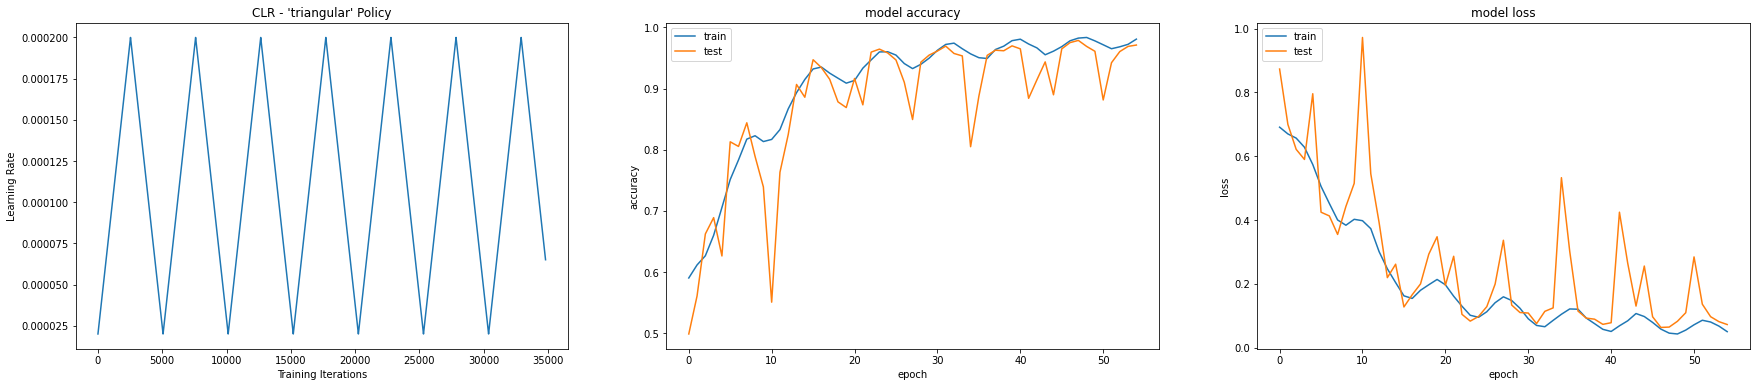

In [ ]:
training_history_plots(history, clr)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

79/79 [==============================] - 9s 110ms/step - loss: 0.0863 - accuracy: 0.9680


In [ ]:
# read in best version of model here
saved_model = tf.keras.models.load_model('drive/My Drive/collab/' + experiment_name + '.h5')

In [ ]:
test_loss, test_acc = saved_model.evaluate(test_generator, verbose=1)

79/79 [==============================] - 9s 109ms/step - loss: 0.0844 - accuracy: 0.4848


In [ ]:
preds = []
actuals = []
for i in range(78):
    X, y = test_generator.next()
    prediction = saved_model.predict(X)
    preds.append(list(np.round(prediction[:, 1])))
    actuals.append(list(y))

actuals = [item for sublist in actuals for item in sublist]
preds = [item for sublist in preds for item in sublist]
print('Accuracy score: {}'.format(accuracy_score(actuals, preds)))
confusion_matrix(actuals, preds)

Accuracy score: 0.9703525641025641


array([[1169,   31],
       [  43, 1253]])